In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, 0.0], cov = 0.01 * np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = 0.01 * np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [20]:
n_samples = 1000

In [21]:
data_train, labels_train, nuisances_train = prepare_data(n_samples)

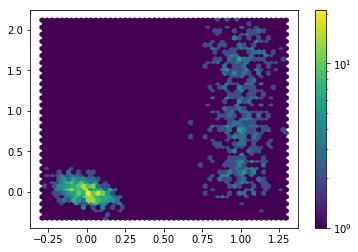

In [22]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [23]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD
import keras.backend as K

Using TensorFlow backend.


In [31]:
bottleneck_size = 5
MINE_batch_size = n_samples

In [32]:
def build_encoder(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(bottleneck_size, activation = "linear")(lay)
    
    encoder = Model(inputs = [inputs], outputs = [outputs])
    return encoder

In [43]:
def build_classifier(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(2, activation = "softmax")(lay)
    
    classifier = Model(inputs = [inputs], outputs = [outputs])
    return classifier

In [44]:
def build_MINE(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(1, activation = "linear")(lay)
    
    MINE_network = Model(inputs = [inputs], outputs = [outputs])
    return MINE_network

In [45]:
def MINE_loss(y_true, y_pred):
    T_xy = y_pred[:MINE_batch_size,:]
    T_x_y = y_pred[MINE_batch_size:,:]
    loss = K.mean(T_xy, axis = 0) - K.log(K.mean(K.exp(T_x_y), axis = 0))
    return -loss

In [46]:
# build the network for mutual information estimation
MINE_input = Input(shape = (bottleneck_size, ), name = 'MINE_input')
MINE_network = build_MINE(MINE_input)
MINE_opt = MINE_opt = Adam(lr = 0.01, beta_1 = 0.4, beta_2 = 0.6, epsilon = K.epsilon(), decay = 0.1)
MINE_network.compile(loss = MINE_loss, optimizer = MINE_opt, metrics = [])

In [47]:
encoder_input = Input(shape = (2,), name = 'encoder_input')
encoder = build_encoder(encoder_input)
encoder_opt = Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
encoder.compile(loss = 'categorical_crossentropy', optimizer = encoder_opt, metrics = [])

In [48]:
classifier_input = Input(shape = (bottleneck_size,), name = 'classifier_input')
classifier = build_classifier(classifier_input)
classifier_opt = Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
classifier.compile(loss = 'categorical_crossentropy', optimizer = classifier_opt, metrics = [])

In [49]:
ec_pair = Model(inputs = [encoder_input, nuisance_input], outputs = [nuisance_input, classifier(encoder(encoder_input))])

In [ ]:
encoder_decoder_pair